In [122]:
import pandas as pd
from sklearn.metrics import silhouette_score
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.sparse import lil_matrix
from sklearn.decomposition import TruncatedSVD 

In [123]:
nba = pd.read_csv('nba_data_processed.csv')
nba.head(100)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,23.0,TOR,38.0,11.0,23.3,3.9,8.1,0.482,...,0.689,2.0,4.6,6.6,1.0,0.6,0.7,1.2,2.1,10.2
1,Steven Adams,C,29.0,MEM,42.0,42.0,27.0,3.7,6.3,0.597,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,Bam Adebayo,C,25.0,MIA,57.0,57.0,35.0,8.4,15.7,0.536,...,0.800,2.6,7.2,9.8,3.2,1.2,0.8,2.5,2.8,21.2
3,Ochai Agbaji,SG,22.0,UTA,39.0,2.0,15.6,1.8,3.8,0.483,...,0.682,0.7,1.1,1.8,0.6,0.2,0.1,0.3,1.4,5.0
4,Santi Aldama,PF,22.0,MEM,56.0,18.0,22.0,3.3,7.0,0.474,...,0.729,1.0,3.6,4.6,1.2,0.7,0.7,0.7,1.9,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Jamal Cain,SF,23.0,MIA,14.0,0.0,13.3,1.9,3.6,0.520,...,0.750,0.9,1.9,2.8,0.6,0.6,0.0,0.3,1.1,4.7
96,Kentavious Caldwell-Pope,SG,29.0,DEN,59.0,59.0,31.5,4.1,8.5,0.480,...,0.842,0.5,2.4,2.9,2.3,1.4,0.5,1.2,2.1,11.4
97,Facundo Campazzo,PG,31.0,DAL,8.0,0.0,6.5,0.4,1.6,0.231,...,0.500,0.0,0.3,0.3,1.1,0.8,0.0,0.4,0.4,1.3
98,Vlatko Čančar,PF,25.0,DEN,47.0,8.0,16.3,2.1,4.2,0.497,...,0.935,0.5,1.9,2.3,1.5,0.4,0.3,0.7,1.6,5.7


In [124]:
nba_df = nba.drop(columns=['Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB','BLK', 'TOV', 'PF'])
nba_df

,Player,Tm,TRB,AST,STL,PTS
0,Precious Achiuwa,TOR,6.6,1.0,0.6,10.2
1,Steven Adams,MEM,11.5,2.3,0.9,8.6
2,Bam Adebayo,MIA,9.8,3.2,1.2,21.2
3,Ochai Agbaji,UTA,1.8,0.6,0.2,5.0
4,Santi Aldama,MEM,4.6,1.2,0.7,9.4
...,...,...,...,...,...,...
644,McKinley Wright IV,DAL,1.3,1.9,0.4,2.9
645,Thaddeus Young,TOR,3.2,1.4,1.1,4.7
646,Trae Young,ATL,2.9,10.2,1.1,27.0
647,Cody Zeller,MIA,2.7,1.0,0.3,6.3


In [125]:
player_name_map = {}
for player_id,name in zip(nba_df['Player'], nba_df['Tm']):
    player_name_map[player_id] = name

In [126]:
columns = ['TRB','AST','STL','PTS']
nba_df = nba_df.dropna(subset=columns)
nba_data = nba_df.drop(['Tm'], axis=1).set_index('Player')
nba_data

,TRB,AST,STL,PTS
Player,,,,
Precious Achiuwa,6.6,1.0,0.6,10.2
Steven Adams,11.5,2.3,0.9,8.6
Bam Adebayo,9.8,3.2,1.2,21.2
Ochai Agbaji,1.8,0.6,0.2,5.0
Santi Aldama,4.6,1.2,0.7,9.4
...,...,...,...,...
McKinley Wright IV,1.3,1.9,0.4,2.9
Thaddeus Young,3.2,1.4,1.1,4.7
Trae Young,2.9,10.2,1.1,27.0


In [127]:
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(nba_data)
labels

array([1, 1, 2, 3, 1, 1, 1, 1, 1, 0, 1, 1, 2, 3, 0, 0, 3, 3, 3, 1, 0, 3,
       0, 3, 2, 1, 1, 1, 2, 2, 3, 3, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       3, 3, 1, 1, 3, 0, 0, 1, 3, 3, 3, 1, 3, 3, 0, 2, 1, 3, 2, 1, 1, 3,
       3, 3, 1, 3, 0, 0, 2, 1, 0, 0, 0, 3, 2, 3, 3, 3, 1, 2, 0, 0, 3, 1,
       0, 3, 2, 3, 3, 0, 3, 1, 0, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 2, 0, 3,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 3, 2, 1, 2, 3, 2, 3, 1, 3, 3, 1, 3, 2,
       3, 3, 1, 3, 3, 0, 0, 0, 1, 2, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 0, 2,
       1, 1, 2, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 2,
       0, 1, 1, 2, 3, 1, 3, 2, 3, 0, 2, 3, 0, 1, 0, 0, 0, 1, 1, 3, 0, 2,
       3, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 0, 0, 1, 2, 3, 3, 3, 3, 0,
       2, 1, 3, 1, 1, 1, 3, 0, 0, 1, 0, 1, 3, 1, 3, 1, 0, 3, 1, 2, 0, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 0, 0, 1, 3, 3,
       1, 2, 2, 2, 2, 1, 0, 1, 0, 3, 3, 1, 1, 1, 2, 1, 1, 3, 0, 0, 0, 1,
       3, 2, 3, 1, 2, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1,

In [128]:
centroids = kmeans.cluster_centers_
centroids

array([[ 5.17368421,  3.05      ,  0.87631579, 13.96666667],
       [ 3.79336493,  1.80853081,  0.66445498,  7.80900474],
       [ 5.95606061,  5.18484848,  1.04090909, 23.77575758],
       [ 1.6167382 ,  0.69270386,  0.31373391,  2.96566524]])

In [129]:
player_cluster = pd.DataFrame(labels, index=nba_data.index, columns=['cluster'])
player_cluster

,cluster
Player,
Precious Achiuwa,1
Steven Adams,1
Bam Adebayo,2
Ochai Agbaji,3
Santi Aldama,1
...,...
McKinley Wright IV,3
Thaddeus Young,3
Trae Young,2


In [130]:
player_cluster['cluster'].value_counts()

3    234
1    210
0    114
2     66
Name: cluster, dtype: int64

(array([0, 1, 2, 3]),
 [Text(0, 0, '3'), Text(1, 0, '1'), Text(2, 0, '0'), Text(3, 0, '2')])

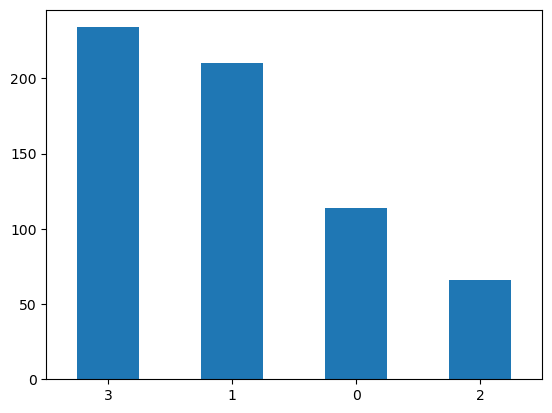

In [131]:
player_cluster['cluster'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

In [132]:
pd.DataFrame(centroids, columns=columns).T

,0,1,2,3
TRB,5.173684,3.793365,5.956061,1.616738
AST,3.050000,1.808531,5.184848,0.692704
STL,0.876316,0.664455,1.040909,0.313734
PTS,13.966667,7.809005,23.775758,2.965665


In [133]:
for cluster,players in player_cluster.groupby("cluster"):
    print("Cluster:", cluster, "Size:", players.shape[0])
    for p_id in players.sample(5).index:
     
        print("\t", p_id, player_name_map[p_id])

Cluster: 0 Size: 114
	 John Collins ATL
	 Collin Sexton UTA
	 Eric Gordon LAC
	 Malik Monk SAC
	 Josh Richardson NOP
Cluster: 1 Size: 210
	 Caleb Martin MIA
	 Larry Nance Jr. NOP
	 Naz Reid MIN
	 Nickeil Alexander-Walker MIN
	 Grant Williams BOS
Cluster: 2 Size: 66
	 Stephen Curry GSW
	 Darius Garland CLE
	 Zach LaVine CHI
	 Tyrese Maxey PHI
	 Jordan Poole GSW
Cluster: 3 Size: 234
	 Raul Neto CLE
	 Bryce McGowens CHO
	 Marko Simonovic CHI
	 Dru Smith BRK
	 A.J. Lawson DAL
